In [14]:
import os, sys, time
import numpy as np
import h5py
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import glob

In [9]:
land_sea_mask_path = "/pscratch/sd/s/shas1693/data/era5/land_sea_mask.npy"

In [10]:
sys.path.insert(1, '../') # insert code repo into path
from utils.YParams import YParams

In [11]:
config_file = "../config/AFNO.yaml"
config_name = "afno_backbone_cmip_p4_e768_depth12_lr1em3_finetune"
params = YParams(config_file, config_name)
model_path = "/pscratch/sd/s/shas1693/results/climate/afno_backbone_cmip_p4_e768_depth12_lr1em3_finetune/0/training_checkpoints/best_ckpt.tar"

In [12]:
# import model
from networks.afnonet import AFNONet
from collections import OrderedDict
from utils.data_loader import get_data_loader

def load_model(model, params, checkpoint_file):
    ''' helper function to load model weights '''
    checkpoint_fname = checkpoint_file
    checkpoint = torch.load(checkpoint_fname)
    try:
        ''' FourCastNet is trained with distributed data parallel
            (DDP) which prepends 'module' to all keys. Non-DDP 
            models need to strip this prefix '''
        new_state_dict = OrderedDict()
        for key, val in checkpoint['model_state'].items():
            name = key[7:]
            if name != 'ged':
                new_state_dict[name] = val  
        model.load_state_dict(new_state_dict)
    except:
        model.load_state_dict(checkpoint['model_state'])
    model.eval() # set to inference mode
    return model

def concat(pl, sl):
    ''' pl is (nt, n_var, n_l, ix, iy)
        sl is (nt, n_var, ix, iy)
    '''
    pl_shape = pl.shape
    sl_shape = sl.shape
    pllist = []
    for i in range(pl_shape[1]): # for each variable 
        pllist.append(pl[:, i, ...])
    pl = np.concatenate(pllist, axis=1)
    tensor = np.concatenate([pl, sl], axis=1)
    return tensor


device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

valid_data_loader, valid_dataset = get_data_loader(params, params.inf_data_path, False, train=False)
img_shape_x = valid_dataset.img_shape_x
img_shape_y = valid_dataset.img_shape_y
params.img_shape_x = img_shape_x
params.img_shape_y = img_shape_y


n_in_channels = params.n_channels
n_out_channels = params.n_channels
in_channels = np.array(list(range(params.n_channels)))
out_channels = np.array(list(range(params.n_channels)))
params['N_in_channels'] = n_in_channels
params['N_out_channels'] = n_out_channels

params.means = np.load(params.global_means_path)[0, out_channels] # needed to standardize wind data
params.stds = np.load(params.global_stds_path)[0, out_channels]
params.time_means = np.load(time_means_path)[0, out_channels]
params.device = device

# load the model
if params.nettype == 'afno':
    model = AFNONet(params).to(device)  # AFNO model 
else:
    raise Exception("not implemented")
# load saved model weights
model = load_model(model, params, model_path)
model = model.to(device)

In [17]:
# means and stds over training data
means = params.means
stds = params.stds

# load climatological means
time_means = params.time_means # temporal mean (for every pixel)
m = torch.as_tensor((time_means - means)/stds)[:, 0:img_shape_x]
m = torch.unsqueeze(m, 0)
# these are needed to compute ACC and RMSE metrics
m = m.to(device, dtype=torch.float)
std = torch.as_tensor(stds[:,0,0]).to(device, dtype=torch.float)

print("Shape of time means = {}".format(m.shape))
print("Shape of std = {}".format(std.shape))

Shape of time means = torch.Size([1, 39, 360, 720])
Shape of std = torch.Size([39])


In [18]:
# define metrics from the definitions above
def lat(j: torch.Tensor, num_lat: int) -> torch.Tensor:
    return 90. - j * 180./float(num_lat-1)

def latitude_weighting_factor(j: torch.Tensor, num_lat: int, s: torch.Tensor) -> torch.Tensor:
    return num_lat * torch.cos(3.1416/180. * lat(j, num_lat))/s

def weighted_rmse_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    #takes in arrays of size [n, c, h, w]  and returns latitude-weighted rmse for each channel
    num_lat = pred.shape[2]
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))
    result = torch.sqrt(torch.mean(weight * (pred - target)**2., dim=(-1,-2)))
    return result

def weighted_acc_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    #takes in arrays of size [n, c, h, w]  and returns latitude-weighted acc for each channel
    num_lat = pred.shape[2]
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))
    result = torch.sum(weight * pred * target, dim=(-1,-2)) / torch.sqrt(torch.sum(weight * pred * pred, dim=(-1,-2)) * torch.sum(weight * target *
    target, dim=(-1,-2)))
    return result

In [19]:
# autoregressive inference helper

def inference(data_slice, model, prediction_length, idx):
    # create memory for the different stats
    n_out_channels = params['N_out_channels']
    acc = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    rmse = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    
    # to conserve GPU mem, only save one channel (can be changed if sufficient GPU mem or move to CPU)
    targets = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
    predictions = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)

     
    with torch.no_grad():
        for i in range(data_slice.shape[0]): 
            if i == 0:
                first = data_slice[0:1]
                future = data_slice[1:2]
                pred = first
                tar = first
                # also save out predictions for visualizing channel index idx
                targets[0,0] = first[0,idx]
                predictions[0,0] = first[0,idx]
                # predict
                future_pred = model(first)
            else:
                if i < prediction_length - 1:
                    future = data_slice[i+1:i+2]
                future_pred = model(future_pred) # autoregressive step

            if i < prediction_length - 1:
                predictions[i+1,0] = future_pred[0,idx]
                targets[i+1,0] = future[0,idx]

            # compute metrics using the ground truth ERA5 data as "true" predictions
            rmse[i] = weighted_rmse_channels(pred, tar) * std
            acc[i] = weighted_acc_channels(pred-m, tar-m)
            print('Predicted timestep {} of {}. {} RMS Error: {}, ACC: {}'.format(i, prediction_length, field, rmse[i,idx], acc[i,idx]))  
            
            pred = future_pred
            tar = future
        
    # copy to cpu for plotting/vis
    acc_cpu = acc.cpu().numpy()
    rmse_cpu = rmse.cpu().numpy()
    predictions_cpu = predictions.cpu().numpy()
    targets_cpu = targets.cpu().numpy()
    
    return acc_cpu, rmse_cpu, predictions_cpu, targets_cpu

In [22]:
variables = ['q925',
'q800',
'q700',
'q600',
'q500',
'q250',
'q50',
't925',
't800',
't700',
 't600',
 't500',
 't250',
 't50',
 'u925',
 'u800',
 'u700',
 'u600',
 'u500',
 'u250',
 'u50',
 'v925',
 'v800',
 'v700',
 'v600',
 'v500',
 'v250',
 'v50',
 'z925',
 'z800',
 'z700',
 'z600',
 'z500',
 'z250',
 'z50',
 'msl',
 't2m',
 'u10',
 'v10']

In [28]:
# setup data for inference
dt = 1 # time step (x 6 hours)
ic = 0 # start the inference from here
prediction_length = 32 # number of steps (x 6 hours)

# which field to track for visualization 
field = 'u10'
idx_vis = variables.index(field) # also prints out metrics for this field

# get prediction length slice from the data
print('Loading inference data')
# load the testing data
files_paths = glob.glob(params.inf_data_path + "/*.h5")
files_paths.sort()
# which year
yr = 0
pl = h5py.File(files_paths[yr], 'r')['pl']
sl = h5py.File(files_paths[yr], 'r')['sl']
valid_data_full = [pl, sl]

n_history = 0

pl = valid_data_full[0][ic:(ic+prediction_length*dt+n_history*dt):dt] #extract valid data from first year
sl = valid_data_full[1][ic:(ic+prediction_length*dt+n_history*dt):dt] #extract valid data from first year
n_pixels = pl.shape[3]
pl = pl[:,:,:,0:n_pixels-1]
sl = sl[:,:,0:n_pixels-1]
data = concat(pl, sl)

print(data.shape)
print("Shape of data = {}".format(data.shape))

Loading inference data
(32, 39, 360, 720)
Shape of data = (32, 39, 360, 720)


In [29]:
data = (data - means)/stds # standardize the data
data = torch.as_tensor(data).to(device, dtype=torch.float) # move to gpu for inference
acc_cpu, rmse_cpu, predictions_cpu, targets_cpu = inference(data, model, prediction_length, idx=idx_vis)

Predicted timestep 0 of 32. u10 RMS Error: 0.0, ACC: 1.0
Predicted timestep 1 of 32. u10 RMS Error: 0.5733477473258972, ACC: 0.9938775300979614
Predicted timestep 2 of 32. u10 RMS Error: 0.7124013900756836, ACC: 0.9906092882156372
Predicted timestep 3 of 32. u10 RMS Error: 0.8302035331726074, ACC: 0.98734450340271
Predicted timestep 4 of 32. u10 RMS Error: 0.881867527961731, ACC: 0.9859314560890198
Predicted timestep 5 of 32. u10 RMS Error: 0.9913073778152466, ACC: 0.9834973812103271
Predicted timestep 6 of 32. u10 RMS Error: 1.105703353881836, ACC: 0.9800449013710022
Predicted timestep 7 of 32. u10 RMS Error: 1.1932690143585205, ACC: 0.9767189025878906
Predicted timestep 8 of 32. u10 RMS Error: 1.342650294303894, ACC: 0.9699331521987915
Predicted timestep 9 of 32. u10 RMS Error: 1.4930002689361572, ACC: 0.9619766473770142
Predicted timestep 10 of 32. u10 RMS Error: 1.6439024209976196, ACC: 0.952776312828064
Predicted timestep 11 of 32. u10 RMS Error: 1.7977043390274048, ACC: 0.9424567

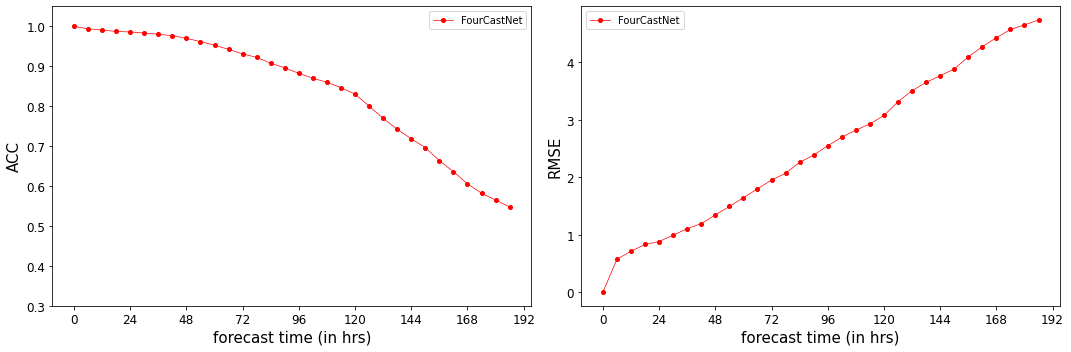

In [30]:
# plot the acc and rmse metrics
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
start = 0
end = prediction_length #  < prediction_lenght forecast

field = 'u10' # change this to other fields such as z500 
idx_metric = variables.index(field) # plot metrics for this field

hrs = np.arange(0, end*6, 6)
ax[0].plot(hrs, acc_cpu[start:end,idx_metric], "o-", label="FourCastNet", ms=4, lw=0.7, color="r")
ax[1].plot(hrs, rmse_cpu[start:end,idx_metric], "o-", label="FourCastNet", ms=4, lw=0.7, color="r")
ax[0].legend()
ax[1].legend()
fsz = "15"
xlist = np.arange(0,end*6+24,24)
ax[0].set_xlabel("forecast time (in hrs)", fontsize=fsz)
ax[1].set_xlabel("forecast time (in hrs)", fontsize=fsz)
ax[0].set_ylabel("ACC", fontsize=fsz)
ax[1].set_ylabel("RMSE", fontsize=fsz)
ax[0].set_ylim(0.3, 1.05)
ax[0].set_xticks(xlist)
ax[1].set_xticks(xlist)
ax[0].tick_params(axis='both', which='both', labelsize=12)
ax[1].tick_params(axis='both', which='both', labelsize=12)
fig.tight_layout()

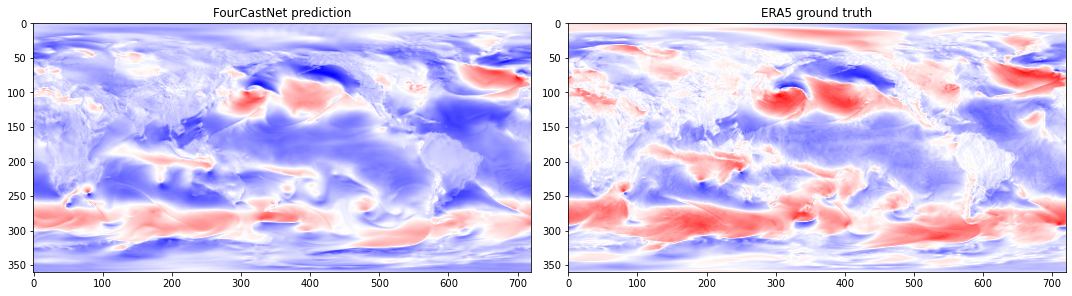

In [32]:
# visualize spatiotemporal predictions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
t = 20 # at 2x6 hours lead time
ax[0].imshow(predictions_cpu[t,0], cmap="bwr")
ax[1].imshow(targets_cpu[t,0], cmap="bwr")
ax[0].set_title("FourCastNet prediction")
ax[1].set_title("ERA5 ground truth")
fig.tight_layout()